In [1]:
from matplotlib import pyplot as plt
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from utils import read_gbench, read_gset
from args import my_get_args
from simcim import SIMCIM
import itertools
import torch
import json
from scipy.signal import savgol_filter

BLS benchmarks for Gset

In [2]:
gbench = read_gbench('./data/gbench.txt')

# Performance

### Reinforcement learning (our approach)

In [53]:
ind = [0, 100, 200, 500]

agent_data = []

for g in range(1,11):
    for s in [1,2,3]:
        with open('checkpoints/ppo/ref-G{}-seed{}.res'.format(g, s)) as f:
            res = json.load(f)
        mx = np.array(res['train_max'])[ind].T/res['bls_bench']
        md = np.array(res['train_median'])[ind].T/res['bls_bench']
        solved = (mx >= 1).astype(float)
        agent_data.append(np.vstack([mx,md,solved]))

agent_data = np.mean(agent_data, axis=0)

In [54]:
agent_data

array([[0.99901538, 0.99959747, 0.99973805, 0.99975526],
       [0.99008277, 0.9900895 , 0.99252138, 0.99788514],
       [0.13333333, 0.6       , 0.73333333, 0.8       ]])

### Heuristics (linear and manually tuned)

In [55]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def tanh_pump(O,S,D,Jmax,amin=0,amax=-1,N=1000):
    i = torch.arange(N,dtype=torch.float32)
    arg = torch.tensor(S,dtype = torch.float32)*(i/N-0.5)
    ret = (Jmax*O*(torch.tanh(arg).numpy() + D) + amin)/(amin-amax)
    return lambda i: float(ret[i])

In [56]:
args = my_get_args('')

config = dict(
    sigma = args.sim_sigma,
    momentum = args.sim_momentum
)
config_tanh = dict(
    sigma = 0.3,
    momentum = 0.9
)
batch_size = 256

comp_data = []

for g in range(1,11):
    for seed in range(30):
        set_seed(seed)
        gr = read_gset('../data/G{}.txt'.format(g), negate=True)
        sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)
        sim.runpump()
        mx = np.max(sim.lastcuts) / gbench[g]
        md = np.median(sim.lastcuts) / gbench[g]
        solved = float(mx >= 1)
        d1 = np.array([[mx,md,solved]]).T
        
        sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config_tanh)
        sim.lr = 0.3
        J = torch.max(torch.sum(torch.abs(torch.tensor(gr)),1)).item()
        tpump = tanh_pump(0.1, 2, -0.9, J, sim.mie, sim.me)
        sim.runpump(pumpfunc=tpump)
        mx = np.max(sim.lastcuts) / gbench[g]
        md = np.median(sim.lastcuts) / gbench[g]
        solved = float(mx >= 1)
        d2 = np.array([[mx,md,solved]]).T
        
        d = np.hstack([d1,d2])
        comp_data.append(d)
    
comp_data = np.mean(comp_data, axis=0)

In [58]:
comp_data

array([[0.99917296, 0.99963928],
       [0.99416741, 0.99477723],
       [0.21333333, 0.66333333]])

### Black-box (CMA-ES)

In [48]:
from scipy.optimize import minimize
import cma

def make_sim_cost(g, config, batch_size, minb, maxb):
    gr = read_gset('../data/G{}.txt'.format(g), negate=True)
    sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)
    J = torch.max(torch.sum(torch.abs(torch.tensor(gr)), 1)).item()
    
    def cost(x, raw=False):
        O, S, D = list(x*(maxb-minb) + minb)
        O = np.exp(O)
        S = np.exp(S)
        pump = tanh_pump(O, S, D, J, sim.mie, sim.me)
        sim.runpump(pumpfunc=pump)
        mx = np.max(sim.lastcuts)
        score = - (mx + np.mean(sim.lastcuts==mx))
        if raw:
            return sim.lastcuts, score
        else:
            return score
    return cost

In [50]:
options = {
    'popsize': 10,
    'bounds': [np.array([0,0,0]), np.array([1,1,1])], 
    'maxfevals': 499,
    'maxiter': 100000
}

cma_data = []

for g in range(1,11):
    for seed in range(3):
        set_seed(seed)
        options['seed'] = seed+1
        sim_cost = make_sim_cost(g, config, batch_size, np.array([-2, -2, -3]), np.array([1,1,3]))

        es = cma.CMAEvolutionStrategy(3*[0.5], 0.5, options)
        while not es.stop():
            solutions = es.ask()
            es.tell(solutions, [sim_cost(x) for x in solutions])
            es.logger.add()
            #es.disp()
            
        cuts, score = sim_cost(es.best.x, raw=True)
        mx = np.max(cuts) / gbench[g]
        md = np.median(cuts) / gbench[g]
        solved = float(mx >= 1)
        d = np.array([[mx,md,solved]]).T
        cma_data.append(d)

        print("G{}, seed {} | best {}, reproduced {}".format(g, seed, -es.best.f, -score))
        
cma_data = np.mean(cma_data, axis=0)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=1, Wed Nov 27 19:02:19 2019)
G1, seed 0 | best 11624.046875, reproduced 11624.0078125
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=2, Wed Nov 27 19:05:46 2019)
G1, seed 1 | best 11624.02734375, reproduced 11624.02734375
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=3, Wed Nov 27 19:09:10 2019)
G1, seed 2 | best 11624.046875, reproduced 11624.02734375
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=1, Wed Nov 27 19:12:38 2019)
G2, seed 0 | best 11620.00390625, reproduced 11617.01171875
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=2, Wed Nov 27 19:16:05 2019)
G2, seed 1 | best 11620.00390625, reproduced 11617.00390625
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=3, Wed Nov 27 19:19:31 2019)
G2, seed 2 | best 11620.00390625, reproduced 11616.0078125
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 3 (seed=1, Wed Nov 27 19:22:58 2019)
G3, seed 0 | best 11622.93359375, reproduced

In [52]:
cma_data

array([[0.99942981],
       [0.99301794],
       [0.63333333]])

### Compile data in a table

In [59]:
data = pd.DataFrame(data=np.hstack([comp_data, cma_data, agent_data]), 
                    index = ['Maximum', 'Median', 'Solved'],
                    columns=['Linear', 'Manual', 'CMA-ES'] + ['Agent-{}'.format(i) for i in ind])
data.loc['Maximum'] = ['{:.4f}'.format(e) for e in data.loc['Maximum'].values]
data.loc['Median']  = ['{:.4f}'.format(e) for e in data.loc['Median'].values]
data.loc['Solved']  = ['{:.2f}'.format(e) for e in data.loc['Solved'].values]

data

,Linear,Manual,CMA-ES,Agent-0,Agent-100,Agent-200,Agent-500
Maximum,0.9992,0.9996,0.9994,0.9990,0.9996,0.9997,0.9998
Median,0.9942,0.9948,0.9930,0.9901,0.9901,0.9925,0.9979
Solved,0.21,0.66,0.63,0.13,0.60,0.73,0.80


In [60]:
print(data.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &  Linear &  Manual &  CMA-ES & Agent-0 & Agent-100 & Agent-200 & Agent-500 \\
\midrule
Maximum &  0.9992 &  0.9996 &  0.9994 &  0.9990 &    0.9996 &    0.9997 &    0.9998 \\
Median  &  0.9942 &  0.9948 &  0.9930 &  0.9901 &    0.9901 &    0.9925 &    0.9979 \\
Solved  &    0.21 &    0.66 &    0.63 &    0.13 &      0.60 &      0.73 &      0.80 \\
\bottomrule
\end{tabular}



# Ablation

### Ablation table

In [53]:
options = ['ref-G{}', 'nofilm-G{}', 'R2-G{}', 
           'scratch-G{}', 'nofilm-scratch-G{}', 'R2-scratch-G{}']
names = itertools.product(['Transfer', 'From scratch'], ['R3', 'R3, no FILM', 'R2'])

index = [100, 200, 500]

data = []

for g in range(1,11):
    for s in [1,2,3]:
        d = []
        for opt in options:
            fn = 'checkpoints/ppo/'+opt.format(g)+'-seed{}.res'.format(s)
            with open(fn) as f:
                res = json.load(f)
            mx = np.array(res['train_max'])[index] / res['bls_bench'][0]
            sl = (mx >= 1.).astype(float)
            d.append(sl)
        data.append(np.hstack(d))
        
data = np.mean(data, axis=0)
data = [['{:.2f}'.format(u) for u in e] for e in data]
data = pd.DataFrame(data=data, 
                    columns=pd.MultiIndex.from_tuples(names), 
                    index=['Solved ({} it.)'.format(i) for i in index])

In [54]:
data

Transfer                   From scratch                  
                       R3 R3, no FILM    R2           R3 R3, no FILM    R2
Solved (100 it.)     0.60        0.63  0.60         0.40        0.37  0.10
Solved (200 it.)     0.73        0.70  0.67         0.47        0.53  0.33
Solved (500 it.)     0.80        0.77  0.70         0.73        0.73  0.53

In [55]:
print(data.to_latex(multicolumn=False))

\begin{tabular}{lllllll}
\toprule
{} & Transfer &             &       & From scratch &             &       \\
{} &       R3 & R3, no FILM &    R2 &           R3 & R3, no FILM &    R2 \\
\midrule
Solved (100 it.) &     0.60 &        0.63 &  0.60 &         0.40 &        0.37 &  0.10 \\
Solved (200 it.) &     0.73 &        0.70 &  0.67 &         0.47 &        0.53 &  0.33 \\
Solved (500 it.) &     0.80 &        0.77 &  0.70 &         0.73 &        0.73 &  0.53 \\
\bottomrule
\end{tabular}



### Ablation plot

In [22]:
options = ['ref-G{}', 'nofilm-G{}', 'R2-G{}', 
           'scratch-G{}', 'nofilm-scratch-G{}', 'R2-scratch-G{}']
names = list(itertools.product(['Transfer', 'From scratch'], ['R3', 'R3, no FILM', 'R2']))

colors = ['g', 'y', 'r', 'b--', 'c--', 'm--']

data = []

for g in range(1,11):
    for s in [1,2,3]:
        d = []
        for opt in options:
            fn = 'checkpoints/ppo/'+opt.format(g)+'-seed{}.res'.format(s)
            with open(fn) as f:
                res = json.load(f)
            mx = np.array(res['train_max']) / res['bls_bench'][0]
            sl = (mx >= 1.).astype(float)
            d.append(sl)
            #d.append(mx)
        data.append(np.hstack(d))
    
mean = np.mean(data, axis=0)
std =  np.std(data, axis=0)

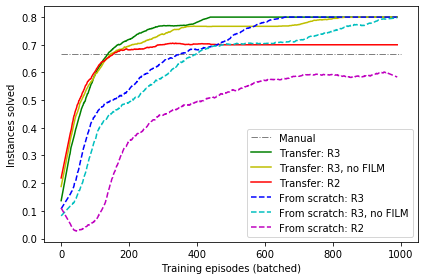

In [23]:
plt.plot([0,1000], [0.666, 0.666], 'gray', label='Manual', ls='-.', lw=1)
for m,s,l,c in zip(mean.T, std.T, names, colors):
    m = savgol_filter(m, 51, 1)
    s = savgol_filter(s, 51, 1)
    plt.plot(m, c, label=': '.join(l))
    #plt.fill_between(np.arange(m.size), m - s/10, m + s/10, color=c, alpha=0.2)
plt.legend()
#plt.ylim(0.999)
#plt.title('Ablation study: fraction of solved instances')
plt.ylabel('Instances solved')
plt.xlabel('Training episodes (batched)')
plt.tight_layout()
plt.savefig('plots_paper/ablation.pdf')
plt.show()

# Analysis

### G2: percentiles

In [57]:
data = []

options = ['ref-G{}-seed{}.res', 'R2-G{}-seed{}.res', 'scratch-G{}-seed{}.res', 'R2-scratch-G{}-seed{}.res']
names = list(itertools.product(['Transfer', 'From scratch'], ['R3', 'R2']))
colors = ['g', 'r', 'b--', 'm--']
graph = 2

data = []
for s in [1,2,3]:
    d = []
    for opt in options:
        with open('checkpoints/ppo/'+opt.format(graph, s)) as f:
            res = json.load(f)
        baseline = res['bls_bench'][0]
        perc = np.array(res['train_percentiles']) + baseline
        #perc = np.array(res['train_max'])
        d.append(perc)
    data.append(np.hstack(d))
data = np.mean(data, axis=0)

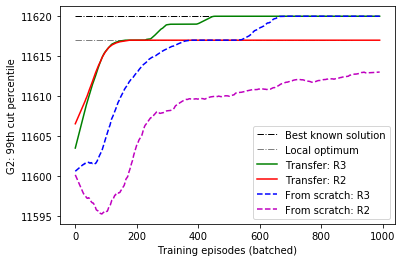

In [58]:
plt.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known solution')
plt.plot([0,900],[baseline-3,baseline-3], 'gray', ls='-.', lw=1,  label='Local optimum')
for d,l,c in zip(data.T, names, colors):
    d = savgol_filter(d, 51, 1)
    plt.plot(d, c, label=': '.join(l))
plt.ylabel('G2: 99th cut percentile')
plt.xlabel('Training episodes (batched)')
plt.legend()
plt.savefig('plots_paper/g2.pdf')
plt.show()

### G2: median

In [7]:
args = my_get_args('')
config = dict(
    sigma = args.sim_sigma,
    momentum = args.sim_momentum
)
batch_size = 256

data = []
g = 2

for seed in range(3):
    set_seed(seed)
    gr = read_gset('../data/G{}.txt'.format(g), negate=True)
    sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)

    J = torch.max(torch.sum(torch.abs(torch.tensor(gr)),1)).item()
    tpump = tanh_pump(0.1, 2, -0.9, J, sim.mie, sim.me)
    sim.runpump(pumpfunc=tpump)
    md = np.median(sim.lastcuts)

    data.append(md)
    
median = np.mean(data)
median

11593.667

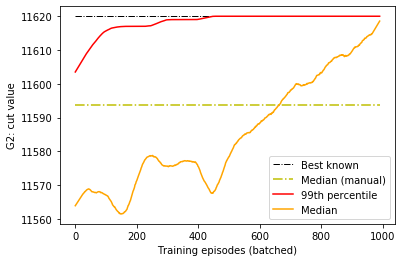

In [8]:
perc = []
med = []
graph = 2

for s in [1,2,3]:
    with open('checkpoints/ppo/ref-G{}-seed{}.res'.format(graph, s)) as f:
        res = json.load(f)
    perc.append(res['train_percentiles'])
    med.append(res['train_median'])
perc = np.mean(perc, axis=0)
med = np.mean(med, axis=0)
baseline = res['bls_bench'][0]

plt.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known')
plt.plot([0,990],[median,median], 'y', ls='-.', label='Median (manual)')
mx = perc.ravel() + baseline
md = med.ravel()
mx = savgol_filter(mx, 51, 1)
md = savgol_filter(md, 51, 1)
plt.plot(mx, 'r', label='99th percentile')
plt.plot(md, 'orange', label='Median')
plt.ylabel('G2: cut value')
plt.xlabel('Training episodes (batched)')
plt.legend()

plt.savefig('plots_paper/median.pdf')

### G2: regularization functions

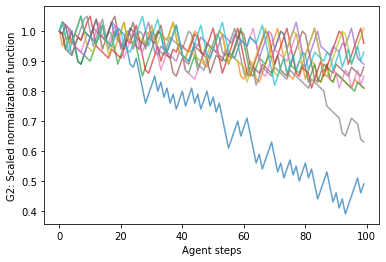

In [10]:
plt.plot(res['spumps'], alpha=0.7)
plt.ylabel('G2: Scaled normalization function')
plt.xlabel('Agent steps')
#plt.tight_layout()
plt.savefig('plots_paper/pumps.pdf')
plt.show()

### G2: losses

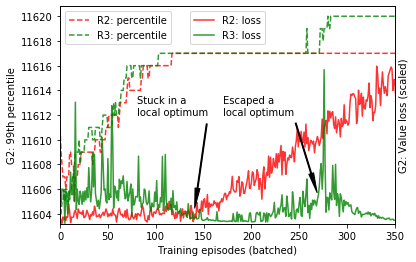

In [90]:
with open('checkpoints/ppo/ref-G2-seed3.res') as f:
    res = json.load(f)
with open('checkpoints/ppo/R2-G2-seed3.res') as f:
    res1 = json.load(f)
baseline = res['bls_bench'][0]

fig, ax1 = plt.subplots()

ax = ax1.twinx()
#ax1.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known')
ax1.plot(np.array(res1['train_percentiles']) + baseline, 'r--', label='R2: percentile', alpha=0.8)
ax1.plot(np.array(res['train_percentiles']) + baseline, 'g--', label='R3: percentile', alpha=0.8)
ax1.set_ylabel('G2: 99th percentile')

loss1 = np.array(res1['vlosses'])/12
loss = np.array(res['vlosses'])
# loss1 = savgol_filter(loss1, 3, 1)
# loss  = savgol_filter(loss,  3, 1)
ax.plot(loss1, 'r', label='R2: loss', alpha=0.8)
ax.plot(loss, 'g', label='R3: loss', alpha=0.8)
ax.set_xlim(0,350)
ax.set_yticks([],[])
ax.set_ylabel('G2: Value loss (scaled)')
ax.set_ylim(0, 0.004) #0.003
ax.annotate('Stuck in a\nlocal optimum', xy=(140,0.0002), xytext=(80, 0.002),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=20))
ax.annotate('Escaped a\nlocal optimum', xy=(270,0.0005), xytext=(170, 0.002),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=20))

ax1.set_xlabel('Training episodes (batched)')

ax1.legend(loc=2)
ax.legend(loc=9)
plt.savefig('plots_paper/loss.pdf')
plt.show()

# Exact cut values

In [63]:
agent = []
bls = []

for g in range(1,11):
    with open('checkpoints/ppo/ref-G{}-seed3.res'.format(g)) as f:
        res = json.load(f)
    agent.append(res['train_max'][-1][0])
    bls.append(res['bls_bench'][0])
    
agent = np.array(agent)
bls = np.array(bls)
data = np.vstack([bls, agent, agent-bls]).astype(int)
data = pd.DataFrame(data, columns=['G'+str(g) for g in range(1,11)], index=['BLS \\cite{bls}', 'Agent', 'delta'])

In [64]:
print(data.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     G1 &     G2 &     G3 &     G4 &     G5 &    G6 &    G7 &    G8 &    G9 &   G10 \\
\midrule
BLS \textbackslash cite\{bls\} &  11624 &  11620 &  11622 &  11646 &  11631 &  2178 &  2006 &  2005 &  2054 &  2000 \\
Agent          &  11624 &  11620 &  11622 &  11646 &  11631 &  2178 &  2006 &  2005 &  2050 &  1999 \\
delta          &      0 &      0 &      0 &      0 &      0 &     0 &     0 &     0 &    -4 &    -1 \\
\bottomrule
\end{tabular}

